#### **1. Load and Inspect Data**




In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('/kaggle/input/ueba-dbscan-iforest/train_data.csv', encoding='latin1')

print("Train Data Shape:", train_data.shape)

print(train_data.head())


Train Data Shape: (528690, 10)
   id            account         group              IP  \
0   1  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ    192.168.1.50   
1   2  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ   192.168.31.46   
2   3  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ     192.168.2.3   
3   4  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ  192.168.145.30   
4   5  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ  192.168.178.92   

                               url   port  vlan      switchIP            time  \
0                http://123.6.4.41  15788   700  129.30.06.37  2021/6/16 7:56   
1           http://104.192.108.154  12665   700  152.91.89.45  2021/6/28 7:58   
2              http://42.236.37.80  25551   700  129.30.06.37   2021/6/1 6:37   
3  http://uf-api6-client.ksord.com  18274   700    162.6.8.29   2021/5/5 8:18   
4           http://101.199.128.170  34572   700    162.0.1.84  2021/6/20 6:52   

      ret  
0  0.1149  
1  0.1801  
2  0.3690  
3  0.1532  
4  0.1449  


In [2]:
print("Total observations:", len(train_data))
print("Unique accounts:", train_data['account'].nunique())
print("Unique IPs:", train_data['IP'].nunique())
print("Unique URLs:", train_data['url'].nunique())
print("Unique switchIPs:", train_data['switchIP'].nunique())

Total observations: 528690
Unique accounts: 151
Unique IPs: 133
Unique URLs: 1319
Unique switchIPs: 133


In [3]:
# Convert 'time' column to datetime and sort by time
train_data['time'] = pd.to_datetime(train_data['time'],format='%Y/%m/%d %H:%M')
train_data = train_data.sort_values(by='time')


In [4]:
# Temporal range of the dataset
start_time = train_data['time'].min()
end_time = train_data['time'].max()


In [5]:
print(f"First observation: {start_time}\nLatest observation: {end_time}")
print("Total observations:", len(train_data))
print("Unique accounts:", train_data['account'].nunique())
print("Unique IPs:", train_data['IP'].nunique())
print("Unique URLs:", train_data['url'].nunique())
print("Unique switchIPs:", train_data['switchIP'].nunique())

First observation: 2021-04-30 18:05:00
Latest observation: 2021-06-29 15:58:00
Total observations: 528690
Unique accounts: 151
Unique IPs: 133
Unique URLs: 1319
Unique switchIPs: 133


#### **2. Filter Data to Select Specific Users**

In [6]:
# Select a subset of users
unique_users = train_data['account'].unique()
selected_users = np.random.choice(unique_users, 5, replace=False)
filtered_df = train_data[train_data['account'].isin(selected_users)]


In [7]:
print("Total observations:", len(filtered_df))
print("Unique accounts:", filtered_df['account'].nunique())
print("Unique IPs:", filtered_df['IP'].nunique())
print("Unique URLs:", filtered_df['url'].nunique())
print("Unique switchIPs:", filtered_df['switchIP'].nunique())


Total observations: 12526
Unique accounts: 5
Unique IPs: 127
Unique URLs: 1044
Unique switchIPs: 131


#### **2.1 Filter Data to Select Specific Time Ranges**

In [8]:
# Define the time range
start_date = '2021-06-22'
end_date = '2021-06-29'

# Filter data within the time range
sample_df = filtered_df[filtered_df['time'].between(start_date, end_date)]
sample_df.set_index('time', inplace=True, drop=False)

In [9]:
print("Total observations:", len(sample_df))
print("Unique accounts:", sample_df['account'].nunique())
print("Unique IPs:", sample_df['IP'].nunique())
print("Unique URLs:", sample_df['url'].nunique())
print("Unique switchIPs:", sample_df['switchIP'].nunique())


Total observations: 1572
Unique accounts: 5
Unique IPs: 110
Unique URLs: 673
Unique switchIPs: 113


In [10]:
sample_df.columns

Index(['id', 'account', 'group', 'IP', 'url', 'port', 'vlan', 'switchIP',
       'time', 'ret'],
      dtype='object')

In [11]:
sample_df = sample_df.drop(columns=['id', 'group', 'port', 'vlan','ret', 'switchIP'])

In [12]:
sample_df.shape

(1572, 4)

Identify various types of variables in our df.

In [13]:
# numerical_features = [feature for feature in filtered_df.columns if sample_df[feature].dtypes != 'O' and sample_df[feature].dtype in ['int64', 'float64']]
# discrete_features=[feature for feature in numerical_features if len(filtered_df[feature].unique())<15]
# continuous_feature=[feature for feature in numerical_features if feature not in discrete_features]


 #### **3. Label Encoding for categorical variables**
 - assigns a unique integer to each category in a categorical feature.

In [14]:
categorical_features=[feature for feature in sample_df.columns if sample_df[feature].dtypes=='O']


In [15]:
categorical_features

['account', 'IP', 'url']

In [16]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for feature in categorical_features:
    sample_df[feature + '_encoded'] = le.fit_transform(sample_df[feature])
    

In [17]:
sample_df.head(3)

,account,IP,url,time,account_encoded,IP_encoded,url_encoded
time,,,,,,,
2021-06-22 00:00:00,wangyang@qq.com,192.168.174.130,http://www.linuxhelp.org,2021-06-22 00:00:00,4,60,626
2021-06-22 00:02:00,wangyang@qq.com,192.168.22.121,http://oimagec5.ydstatic.com,2021-06-22 00:02:00,4,70,411
2021-06-22 00:02:00,wangyang@qq.com,192.168.170.201,http://www.tycqxs.com,2021-06-22 00:02:00,4,57,651


In [18]:
# Drop the original categorical columns 
sample_df = sample_df.drop(columns=categorical_features)
sample_df.head(5)

,time,account_encoded,IP_encoded,url_encoded
time,,,,
2021-06-22 00:00:00,2021-06-22 00:00:00,4,60,626
2021-06-22 00:02:00,2021-06-22 00:02:00,4,70,411
2021-06-22 00:02:00,2021-06-22 00:02:00,4,57,651
2021-06-22 00:02:00,2021-06-22 00:02:00,1,72,491
2021-06-22 00:03:00,2021-06-22 00:03:00,4,103,391


In [19]:
# **Feature Hashing for categorical variables**

# from sklearn.feature_extraction import FeatureHasher

# cols = sample_df[["account", "IP", "url"]]

# # Convert each value in the selected columns to a string
# cols = cols.map(str)

# # Convert selected columns to list of dictionaries
# data_dict = cols.to_dict(orient='records')

# # Initialize feature hasher
# hasher = FeatureHasher(n_features=10, input_type='string')
# hashed_features = hasher.fit_transform(data_dict).toarray()

# # Convert hashed features to DataFrame
# hashed_df = pd.DataFrame(hashed_features, columns=[f'feature_{i}' for i in range(hashed_features.shape[1])])

# # Combine the original DataFrame with hashed features
# result_df = pd.concat([cols.reset_index(), hashed_df], axis=1)

#### **4.Pre-processing of Time column**

In [20]:
# Extract numerical features

sample_df['hour'] = sample_df['time'].dt.hour
sample_df['day_of_week'] = sample_df['time'].dt.day_of_week
sample_df['month'] = sample_df['time'].dt.month


In [21]:
sample_df.drop('time', axis=1, inplace=True)

In [22]:
sample_df.head(4)

,account_encoded,IP_encoded,url_encoded,hour,day_of_week,month
time,,,,,,
2021-06-22 00:00:00,4,60,626,0,1,6
2021-06-22 00:02:00,4,70,411,0,1,6
2021-06-22 00:02:00,4,57,651,0,1,6
2021-06-22 00:02:00,1,72,491,0,1,6


#### **5. Preprocess (Normalize) the Data**
**5.1 StandardScaler** 
- Scales the features to have a mean of 0 and a standard deviation of 1.
- Good when the data has outliers, as standardization is less affected by outliers compared to normalization.

In [23]:
from sklearn.preprocessing import StandardScaler

# Normalize data
standard_scaler = StandardScaler()
scaled_data = standard_scaler.fit_transform(sample_df)

# Convert scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=sample_df.columns, index=sample_df.index)


In [24]:
scaled_df.columns

Index(['account_encoded', 'IP_encoded', 'url_encoded', 'hour', 'day_of_week',
       'month'],
      dtype='object')

**5.2 Min-Max Scaling**
- Scales the features to a common range, typically between 0 and 1.  
- It preserves the shape of the original data distribution.
- Good when you don't know the distribution of the data or when it is not Gaussian.


In [25]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

# Fit and transform the df
scaled_df = pd.DataFrame(min_max_scaler.fit_transform(sample_df), columns=sample_df.columns)

# print("Original DataFrame:")
# print(sample_df)

# print("\nScaled DataFrame:")
# print(scaled_data)


**5.3 Robust Scaling**
- scales the features using statistics that are robust to outliers, such as the median and the interquartile range (IQR).
- resistant to the influence of outliers compared to standard scaling techniques like Min-Max Scaling or Standard Scaling.

In [26]:
from sklearn.preprocessing import RobustScaler

# Create a RobustScaler object
robust_scaler = RobustScaler()

# Fit and transform the DataFrame
scaled_df = pd.DataFrame(robust_scaler.fit_transform(sample_df), columns=sample_df.columns)

print("Original DataFrame:")
print(sample_df)
print("\nScaled DataFrame:")
print(scaled_df)

Original DataFrame:
                     account_encoded  IP_encoded  url_encoded  hour  \
time                                                                  
2021-06-22 00:00:00                4          60          626     0   
2021-06-22 00:02:00                4          70          411     0   
2021-06-22 00:02:00                4          57          651     0   
2021-06-22 00:02:00                1          72          491     0   
2021-06-22 00:03:00                4         103          391     0   
...                              ...         ...          ...   ...   
2021-06-28 23:33:00                2          15          368    23   
2021-06-28 23:41:00                4          28           84    23   
2021-06-28 23:47:00                1          92          322    23   
2021-06-28 23:49:00                2          11          576    23   
2021-06-28 23:57:00                4           9          636    23   

                     day_of_week  month  
time          

#### 6. **Feature Extraction**
- Identify the most significative variables of the dataset.
#### 6.1 Correlation Matrix - Features with high correlation coefficients are likely to be more important.

In [27]:
# Get the feature names from the original DataFrame
original_feature_names = sample_df.columns

# Apply correlation matrix 
corr_matrix = scaled_df.corr()

# Create a mapping dictionary
feature_mapping = {f'feature{i+1}': original_feature_names[i] for i in range(len(original_feature_names))}

# Rename the columns in the correlation matrix
corr_matrix = corr_matrix.rename(columns=feature_mapping, index=feature_mapping)


In [28]:
corr_matrix

,account_encoded,IP_encoded,url_encoded,hour,day_of_week,month
account_encoded,1.000000,0.072452,-0.020605,-0.290575,0.013654,NaN
IP_encoded,0.072452,1.000000,0.025073,0.010166,0.027724,NaN
url_encoded,-0.020605,0.025073,1.000000,-0.007932,0.021962,NaN
hour,-0.290575,0.010166,-0.007932,1.000000,-0.015793,NaN
day_of_week,0.013654,0.027724,0.021962,-0.015793,1.000000,NaN
month,NaN,NaN,NaN,NaN,NaN,NaN


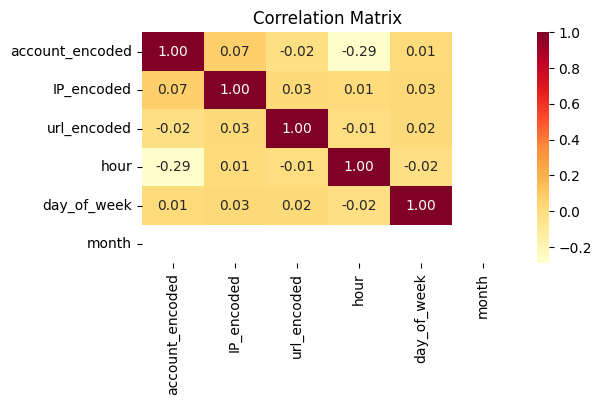

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()





- The feature pair with the highest correlation score is **account_encoded** and **hour**, with a correlation coefficient of 0.45.

- Based on the relationship of the variables after visualizing the correlation matrix we decided to remove the 'month' variable as it has a weak correlation with the other variables.

In [30]:
scaled_df = scaled_df.drop('month', axis=1)
scaled_df.columns


Index(['account_encoded', 'IP_encoded', 'url_encoded', 'hour', 'day_of_week'], dtype='object')

#### 6.2 Information Gain -- Features with higher information gain are considered more important. 


In [31]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

# create a dummy variable as information gain expects the target variable to be provided
y = [0] * len(scaled_df) 

# Calculate the information gain for each feature
info_gain = mutual_info_classif(scaled_df, y)

# Create a DataFrame with the feature names and their corresponding information gain
info_gain_df = pd.DataFrame({'feature': scaled_df.columns, 'info_gain': info_gain})

# Sort the DataFrame by information gain in descending order
info_gain_df = info_gain_df.sort_values('info_gain', ascending=False)

# Select the top 3 features
top_features = info_gain_df['feature'].head(3).tolist()

info_gain_df

,feature,info_gain
0,account_encoded,2.886580e-15
1,IP_encoded,2.886580e-15
2,url_encoded,2.886580e-15
3,hour,2.886580e-15
4,day_of_week,2.886580e-15


In [32]:
print("Top 3 features based on information gain:", top_features)


Top 3 features based on information gain: ['account_encoded', 'IP_encoded', 'url_encoded']


# 7. **DBSCAN algorithm**
## 7.1 **Hyperparameter tuning**

### 7.1.1 ELBOW METHOD

Choosing the most appropriate values for hyperparameters of DBSCAN applying the **K-Nearest Neighbours** approach as explained in these two papers: Sander et al. 1998 and Schubert et al. 2017 (both papers from the original DBSCAN authors).

Here's a condensed version of their approach: If you have N-dimensional data to begin, then choose n_neighbors in sklearn.neighbors.NearestNeighbors to be equal to **2xN - 1**, and find out distances of the K-nearest neighbors **(K being 2xN - 1)** for each point in your dataset. Sort these distances out and plot them to find the "elbow" which separates noisy points (with high K-nearest neighbor distance) from points (with relatively low K-nearest neighbor distance) which will most likely fall into a cluster. The distance at which this "elbow" occurs is your point of optimal eps.

In [33]:
scaled_df.shape

(1572, 5)

In [34]:
from sklearn.neighbors import NearestNeighbors

# Number of features-- in our case 3, Twice the number of features
min_samples = scaled_df.shape[1] * 2
k = min_samples if min_samples>2 else 2
nrbs = NearestNeighbors(n_neighbors=k).fit(scaled_df)
distances, indicies = nrbs.kneighbors(scaled_df)

In [35]:
print("Min number of samples:" + str(min_samples))
print("Shape of distances matrix:" + str(distances.shape) + "\n")

for enum, row in enumerate(distances[:5]):
    print("Observation: " + str(enum) + ": " + str([round(x,2) for x in row]))



Min number of samples:10
Shape of distances matrix:(1572, 10)

Observation: 0: [0.0, 0.09, 0.3, 0.4, 0.44, 0.47, 0.56, 0.58, 0.6, 0.61]
Observation: 1: [0.0, 0.22, 0.25, 0.27, 0.28, 0.28, 0.29, 0.32, 0.32, 0.33]
Observation: 2: [0.0, 0.09, 0.29, 0.37, 0.49, 0.52, 0.56, 0.62, 0.63, 0.66]
Observation: 3: [0.0, 0.22, 0.35, 0.4, 0.4, 0.42, 0.42, 0.43, 0.46, 0.47]
Observation: 4: [0.0, 0.22, 0.26, 0.28, 0.29, 0.3, 0.32, 0.35, 0.36, 0.37]


In [36]:
# the last cell of each row represents the distance of the k'th farthest point
scaled_df['knn_farthest_dist'] = distances[:,-1]
scaled_df.head()

,account_encoded,IP_encoded,url_encoded,hour,day_of_week,knn_farthest_dist
0,1.5,0.184332,0.870149,-0.428571,-0.5,0.606914
1,1.5,0.368664,0.228358,-0.428571,-0.5,0.329253
2,1.5,0.129032,0.944776,-0.428571,-0.5,0.655944
3,0.0,0.405530,0.467164,-0.428571,-0.5,0.466480
4,1.5,0.976959,0.168657,-0.428571,-0.5,0.370999


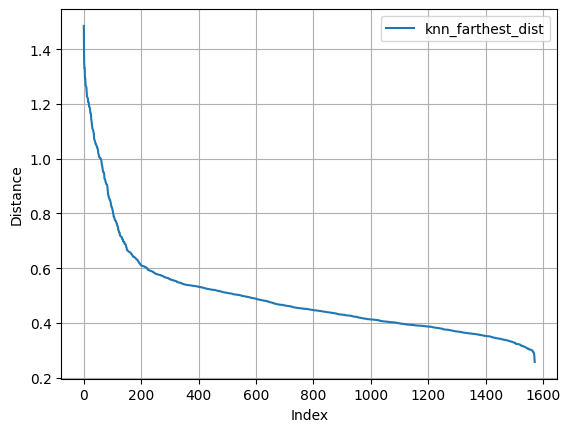

In [37]:
import matplotlib.pyplot as plt
scaled_df.sort_values('knn_farthest_dist', ascending=False).reset_index()[['knn_farthest_dist']].plot()
plt.xlabel('Index')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

From the plot above, it can be inferred that the optimal value for eps can be assumed at around 0.3 for the given dataset.

### 7.1.2 **GridSearchCV**

GridSearch in the DBSCAN algorithm involves systematically searching for optimal hyperparameters such as epsilon and minimum samples per cluster, aiming to enhance the clustering performance. 
-  Performs hyperparameter optimization using cross-validation to determine the best set of hyperparameters for a given model and dataset.

In [38]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClusterMixin

class DBSCANWrapper(BaseEstimator, ClusterMixin):
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)
    
    def fit(self, X, y=None):
        self.dbscan.fit(X)
        return self
    
    def fit_predict(self, X, y=None):
        return self.dbscan.fit_predict(X)
    
def silhouette_scorer(estimator, X):
    clusters = estimator.fit_predict(X)
    if len(set(clusters)) > 1:
        score = silhouette_score(X, clusters)
    else:
        score = -1  # or some other value to indicate that the score isn't valid
    return score


param_grid = {
    'eps': [0.2, 0.5, 0.7, 1.0],
    'min_samples': [3, 5, 10, 12, 15]
}

dbscan = DBSCANWrapper()
grid_search = GridSearchCV(estimator=dbscan, param_grid=param_grid, scoring=silhouette_scorer, cv=3)

grid_search.fit(scaled_df)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest Parameters: {best_params} - Best Silhouette Score: {best_score}")


Best Parameters: {'eps': 0.2, 'min_samples': 3} - Best Silhouette Score: 0.08701591204625936


In [39]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
epsilon = 0.2
min_samples=3
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_df)

####  **7.3 Identify the core and the outliers for DBSCAN**

In [40]:
# Identify the core and the outliers
import numpy as np

core_samples = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

In [41]:
# Check the number of clusters after DBSCAN algorithm (ignoring noise if present)

n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')


Estimated number of clusters: 81
Estimated number of noise points: 1254


#### **7.4 DBSCAN clustering 3D**

In [42]:
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN

X = scaled_df[['account_encoded', 'IP_encoded', 'url_encoded']].values

# Apply DBSCAN
epsilon = 0.2
min_samples = 3
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = dbscan.fit_predict(X)

# Separate normal points and anomalies
normal_points = X[labels != -1]
normal_labels = labels[labels != -1]
anomalies = X[labels == -1]

# Create a Plotly Scatter3D plot
fig = go.Figure()

# Add normal points
fig.add_trace(go.Scatter3d(
    x=normal_points[:, 0],
    y=normal_points[:, 1],
    z=normal_points[:, 2],
    mode='markers',
    marker=dict(
        color=normal_labels,
        colorscale='Viridis',
        size=5,
        line=dict(color='black', width=0.5)
    ),
    name='Normal Points'
))

# Add anomalies as red 'x' markers
fig.add_trace(go.Scatter3d(
    x=anomalies[:, 0],
    y=anomalies[:, 1],
    z=anomalies[:, 2],
    mode='markers',
    marker=dict(
        color='red',
        symbol='x',
        size=2.6,
        line=dict(color='red', width=1)
    ),
    name='Anomalies'
))

fig.update_layout(
    title='DBSCAN Clustering',
    scene=dict(
        xaxis_title='account_encoded',
        yaxis_title='IP_encoded',
        zaxis_title='url_encoded'
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()

#### **7.5 DBSCAN Clustering in 3D**

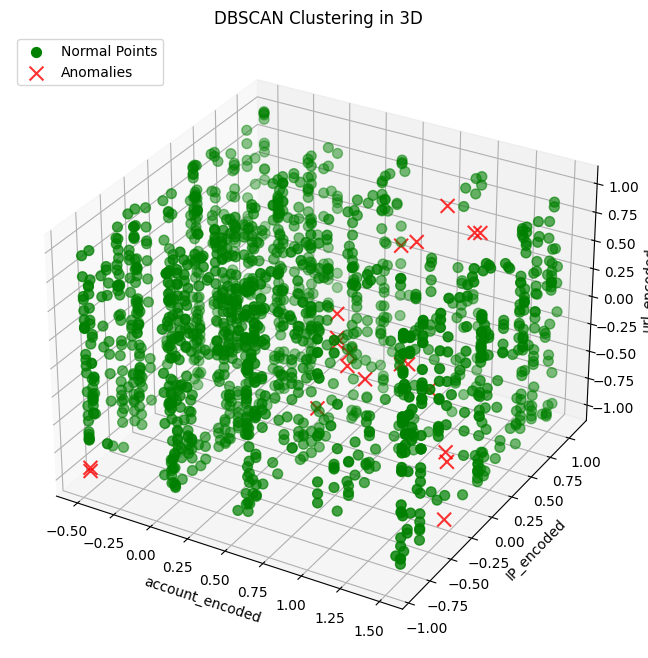

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import numpy as np

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the normal (clustered) points in blue
normal_points = ax.scatter(X[labels != -1, 0], X[labels != -1, 1], X[labels != -1, 2], c='green', s=50)

# Plot the anomalies (noise points) in red with 'x' markers
anomalies = ax.scatter(X[labels == -1, 0], X[labels == -1, 1], X[labels == -1, 2], marker='x', c='#FF0000', s=100, alpha=0.8)

# Set labels and title
ax.set_xlabel('account_encoded')
ax.set_ylabel('IP_encoded')
ax.set_zlabel('url_encoded')
ax.set_title('DBSCAN Clustering in 3D')

# Add a legend
ax.legend([normal_points, anomalies], ['Normal Points', 'Anomalies'], loc='upper left')

plt.show()

## 8. **Isolation forest**
### 8.1 **Hyperparamter tuning** 

Contamination: This is a parameter that the algorithm is quite sensitive to; it refers to the expected proportion of outliers in the data set. This is used when fitting to define the threshold on the scores of the samples. 

In [44]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest

# Custom scoring function for unsupervised learning
def unsupervised_scorer(estimator, X):
    # Predict the anomaly scores
    scores_pred = estimator.decision_function(X)
    # Compute the silhouette score
    silhouette = silhouette_score(X, scores_pred < estimator.contamination)
    return silhouette

# Initialize the Isolation Forest model with contamination parameter
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Define a range of parameters to tune, excluding the contamination parameter
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': [0.25, 0.5, 0.75],
    'max_features': [1.0, 0.7, 0.5]
}

X = scaled_df[['account_encoded', 'IP_encoded', 'url_encoded']].values

# Set up the grid search with the custom scorer
grid_search = GridSearchCV(estimator=iso_forest, param_grid=param_grid, scoring=unsupervised_scorer, cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

# the best estimator for further analysis
best_iso_forest = grid_search.best_estimator_

Best parameters: {'max_features': 1.0, 'max_samples': 0.25, 'n_estimators': 150}
Best score: 0.14433448713143074


In [45]:
#scaled_df.columns

In [46]:
scaled_df = scaled_df.drop(['knn_farthest_dist'], axis=1)

#### 8.2 **Train and predict with Isolation Forest**

In [47]:
from sklearn.ensemble import IsolationForest

# Retrain the model with the best hyperparameters

iso_forest = IsolationForest(**grid_search.best_params_)
iso_labels = iso_forest.fit_predict(scaled_df)

#### **8.3 Check the number of outliers after applying IForest algorithm**

In [48]:

n_clusters_ = len(set(iso_labels)) - (1 if -1 in iso_labels else 0)
n_noise_ = list(iso_labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

Estimated number of clusters: 1
Estimated number of noise points: 927


### **9. Evaluate and Visualize Results for both algorithms**

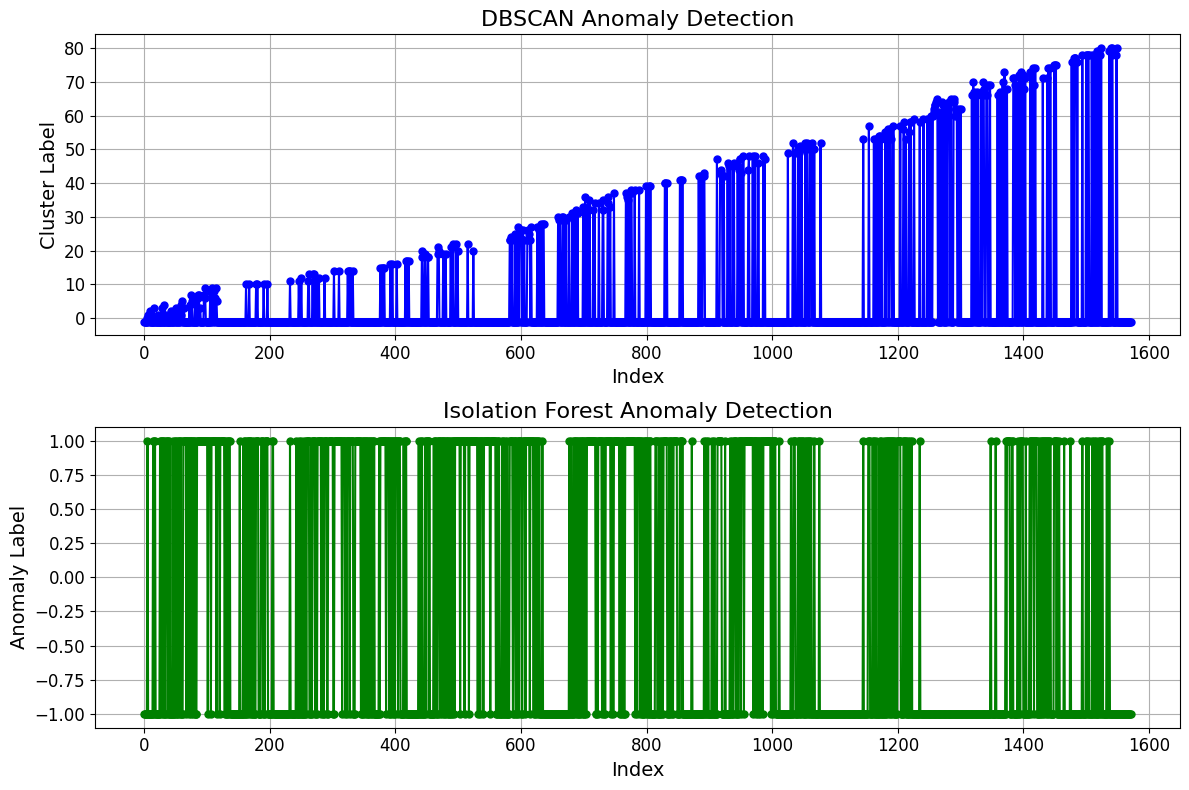

In [49]:
import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(12, 8))

# Plot DBSCAN labels
plt.subplot(2, 1, 1)
plt.plot(scaled_df.index, clusters, marker='o', linestyle='-', color='b', markersize=5)
plt.title('DBSCAN Anomaly Detection', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Cluster Label', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot Isolation Forest labels
plt.subplot(2, 1, 2)
plt.plot(scaled_df.index, iso_labels, marker='o', linestyle='-', color='g', markersize=5)
plt.title('Isolation Forest Anomaly Detection', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Anomaly Label', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


#### **9.1 Comparing results between algorithms**

**DBSCAN Silhouette Coefficient**

In [50]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Coefficient
silhouette_avg = silhouette_score(scaled_df, clusters)
print(f"Silhouette Coefficient: {silhouette_avg}")

Silhouette Coefficient: -0.41509273300068444


**Isolation Forest Silhouette Coefficient**

In [51]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Coefficient
silhouette_isolation_f = silhouette_score(scaled_df, iso_labels)
print(f"Silhouette Coefficient: {silhouette_isolation_f}")

Silhouette Coefficient: 0.025118025482636648


**Sensitivity to Density:** DBSCAN is more sensitive to local density variations and can identify multiple clusters, while Isolation Forest is more focused on identifying global outliers.

The large difference in the number of clusters/outliers identified by DBSCAN and Isolation Forest is due to the fundamental differences in how these algorithms work and the assumptions they make about the data.